Referenced Articles


*   [Hyperparameter Tuning for C and Gamma](https://towardsdatascience.com/hyperparameter-tuning-for-support-vector-machines-c-and-gamma-parameters-6a5097416167)
- [Using PCA](https://apsl.tech/en/blog/using-principal-component-analysis-pac-data-explore-step-step/)



## Setup and Imports

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
# import torch.nn as nn
# import torch.optim as optim
# import torchvision
# from torchvision import datasets, models
from torchvision.transforms import v2
from torchvision.datasets import ImageFolder
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
# from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
from collections import Counter
from tqdm.notebook import tqdm
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import image

## Dataset

In [ ]:
# Define data transformations (resize, normalize, etc.)
resize_transform = v2.Compose([
    v2.Resize((224, 224)),  # Resize images to a common size
])
validation_transform = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])

# Define the dataset path (the directory containing "benign" and "malignant" subfolders)
dataset_path = '/content/drive/MyDrive/IT1244/images'
# dataset_path = 'images'

# Load the dataset using ImageFolder
dataset = ImageFolder(root=dataset_path, transform=resize_transform)

train_ratio = 0.8  # You can adjust this ratio as needed
train_size = int(train_ratio * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = train_test_split(dataset, test_size=test_size, train_size=train_size, random_state=42)

# Get the class-to-index mapping
class_to_idx = dataset.class_to_idx

# Get the class names
class_names = list(class_to_idx.keys())

# Use Counter to count the number of samples in each class
class_counts = dict(Counter(dataset.targets))

# Print the number of samples in each class
for class_name in class_names:
    count = class_counts[class_to_idx[class_name]]
    print(f"Class '{class_name}': {count} samples")

Class 'benign': 77 samples
Class 'malignant': 153 samples


In [ ]:
benign_imgs = [fn for fn in os.listdir(f'{dataset_path}/benign') if fn.endswith('.jpg')]
malignant_imgs = [fn for fn in os.listdir(f'{dataset_path}/malignant') if fn.endswith('.jpg')]

In [ ]:
# making n X m matrix
def img2np_flatten(path, list_of_filename, size = (224, 224)):
    # iterating through each file
    for fn in list_of_filename:
        fp = path + fn
        current_image = image.load_img(fp, target_size = size,
                                       color_mode = 'grayscale')
        # covert image to a matrix
        img_ts = image.img_to_array(current_image)
        # turn that into a vector / 1D array
        img_ts = [img_ts.ravel()]
        try:
            # concatenate different images
            full_mat = np.concatenate((full_mat, img_ts))
        except UnboundLocalError:
            # if not assigned yet, assign one
            full_mat = img_ts
    return full_mat

# run it on our folders
benign_images = img2np_flatten(f'{dataset_path}/benign/', benign_imgs)
malignant_images = img2np_flatten(f'{dataset_path}/malignant/', malignant_imgs)

## PCA with SVM

Number of PC:  16


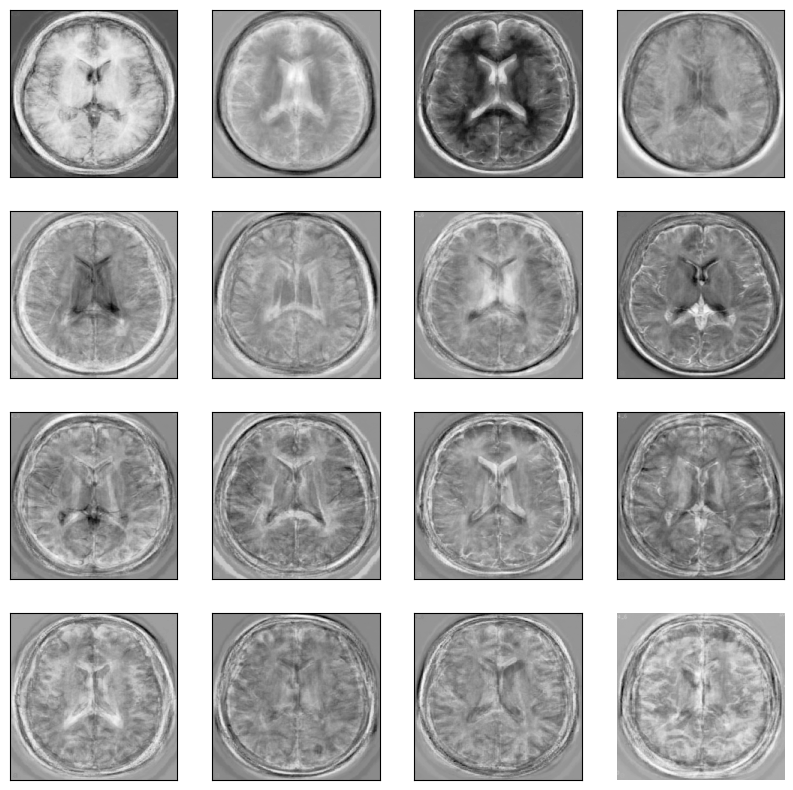

Number of PC:  25


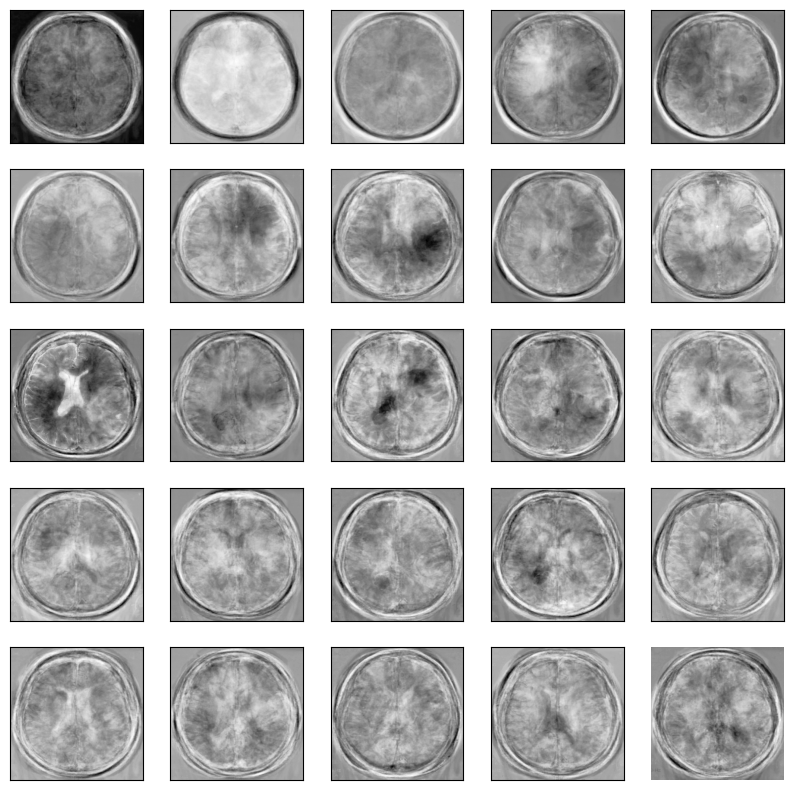

In [ ]:
from sklearn.decomposition import PCA
from math import ceil

def eigenimages(full_mat, title, n_comp = 0.7, size = (224, 224)):
    # fit PCA to describe n_comp * variability in the class
    pca = PCA(n_components = n_comp, whiten = True)
    pca.fit(full_mat)
    print('Number of PC: ', pca.n_components_)
    return pca

def plot_pca(pca, size = (224, 224)):
    # plot eigenimages in a grid
    n = pca.n_components_
    fig = plt.figure(figsize=(10, 10))
    r = int(n**.5)
    c = ceil(n/ r)
    for i in range(n):
        ax = fig.add_subplot(r, c, i + 1, xticks = [], yticks = [])
        ax.imshow(pca.components_[i].reshape(size),
                  cmap='Greys_r')
    plt.axis('off')
    plt.show()

plot_pca(eigenimages(benign_images, 'BENIGN'))
plot_pca(eigenimages(malignant_images, 'MALIGNANT'))

In [ ]:
print(len(components))

224


In [ ]:
print([(i, val) for i, val in enumerate(cumulative_variance) if val > 0.9])

[(86, 0.9012126)]


### PCA with SVM

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, auc, precision_recall_curve

In [ ]:
from sklearn.preprocessing import StandardScaler
X_std = StandardScaler().fit_transform(np.concatenate((benign_images, malignant_images)))
print(X_std.shape)

(224, 50176)


In [ ]:
num_benign = len(benign_images)
num_malignant = len(malignant_images)
y = np.concatenate((np.zeros(num_benign), np.ones(num_malignant)))

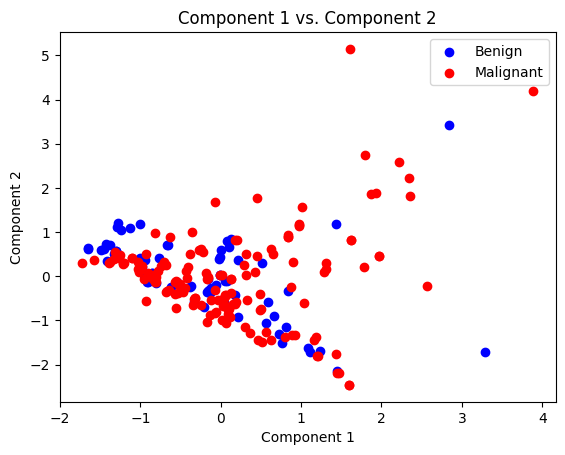

In [ ]:
from sklearn.decomposition import PCA

# Assuming X is your data
pca = PCA(n_components=0.9, whiten=True)  # Reduce to 2 components
components = pca.fit_transform(X_std)
component1 = components[:, 0]
component2 = components[:, 1]

# Extract the labels for benign and malignant samples
benign_labels = np.zeros(len(benign_images))  # Assuming 0 represents benign
malignant_labels = np.ones(len(malignant_images))  # Assuming 1 represents malignant

# Create a list of labels for all data points
all_labels = np.concatenate((benign_labels, malignant_labels))

# Create a scatter plot and use different colors for benign and malignant points
plt.scatter(component1[all_labels == 0], component2[all_labels == 0], label='Benign', c='b')
plt.scatter(component1[all_labels == 1], component2[all_labels == 1], label='Malignant', c='r')

plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('Component 1 vs. Component 2')
plt.legend()
plt.show()

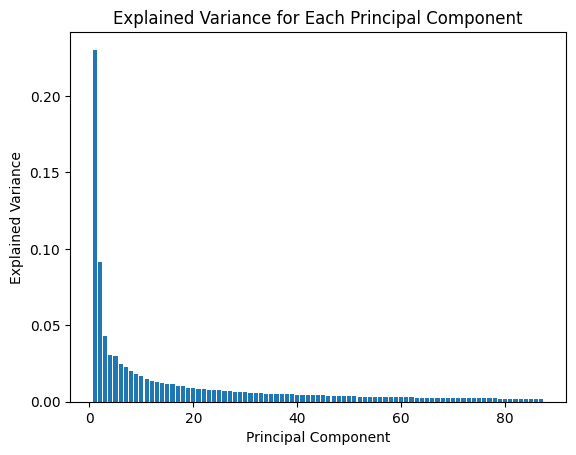

In [ ]:
# Calculate the explained variance for each component
explained_variance = pca.explained_variance_ratio_

# Plot the explained variance
plt.bar(range(1, len(explained_variance) + 1), explained_variance)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance')
plt.title('Explained Variance for Each Principal Component')
plt.show()

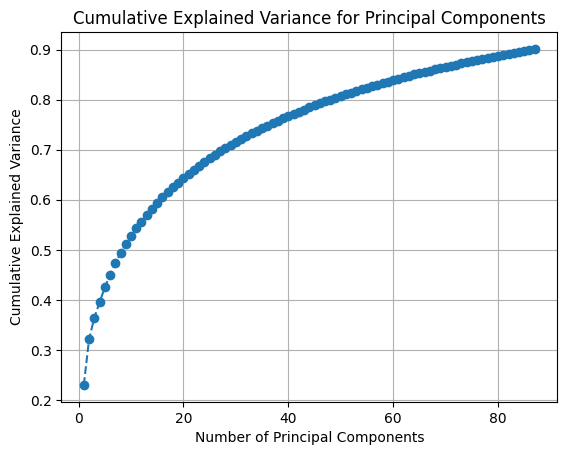

In [ ]:
# Calculate the explained variance for each component
explained_variance = pca.explained_variance_ratio_

# Calculate the cumulative explained variance
cumulative_variance = explained_variance.cumsum()

# Plot the cumulative explained variance
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance for Principal Components')
plt.grid(True)
plt.show()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(components, y, test_size=0.2, random_state=42)

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# Define the parameter grid
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto', 0.1, 1]
}

# Create a GridSearchCV object
svm_classifier = SVC()
grid_search = GridSearchCV(svm_classifier, param_grid, cv=5, scoring='average_precision')  # You can adjust the number of cross-validation folds

# Fit the GridSearchCV object to your training data
grid_search.fit(X_train, y_train)

# Get the best hyperparameters and results
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Hyperparameters:", best_params)
print("Best average precision:", best_score)

Best Hyperparameters: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
Best average precision: 0.9442282926946197


In [ ]:
results_df = pd.DataFrame(grid_search.cv_results_)
results_df = results_df.sort_values(by='rank_test_score')
results_df[:10]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
31,0.003162,0.000494,0.001859,0.000181,10,0.1,rbf,"{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}",0.922127,0.949928,0.951806,0.968688,0.928593,0.944228,0.016859,1
19,0.002528,0.000041,0.001562,0.000035,1,0.1,rbf,"{'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}",0.914904,0.935554,0.951806,0.967717,0.947941,0.943584,0.017641,2
7,0.002525,0.000037,0.001630,0.000019,0.1,0.1,rbf,"{'C': 0.1, 'gamma': 0.1, 'kernel': 'rbf'}",0.913340,0.934425,0.950798,0.967717,0.941760,0.941608,0.017983,3
26,0.002335,0.000031,0.001151,0.000029,10,scale,poly,"{'C': 10, 'gamma': 'scale', 'kernel': 'poly'}",0.896965,0.906148,0.932140,0.930690,0.900312,0.913251,0.015126,4
29,0.002266,0.000024,0.001206,0.000048,10,auto,poly,"{'C': 10, 'gamma': 'auto', 'kernel': 'poly'}",0.894923,0.905959,0.932140,0.929682,0.900312,0.912603,0.015370,5
17,0.002243,0.000197,0.001659,0.000532,1,auto,poly,"{'C': 1, 'gamma': 'auto', 'kernel': 'poly'}",0.889689,0.913802,0.913520,0.912206,0.898451,0.905533,0.009776,6
14,0.002161,0.000044,0.001191,0.000048,1,scale,poly,"{'C': 1, 'gamma': 'scale', 'kernel': 'poly'}",0.887934,0.913112,0.913520,0.909908,0.895514,0.903998,0.010379,7
4,0.002235,0.000016,0.001536,0.000065,0.1,auto,rbf,"{'C': 0.1, 'gamma': 'auto', 'kernel': 'rbf'}",0.867552,0.899118,0.926112,0.903559,0.902718,0.899812,0.018737,8
1,0.004288,0.001604,0.001618,0.000062,0.1,scale,rbf,"{'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}",0.867552,0.899118,0.926112,0.901731,0.903965,0.899696,0.018728,9
32,0.002525,0.000101,0.001333,0.000133,10,0.1,poly,"{'C': 10, 'gamma': 0.1, 'kernel': 'poly'}",0.894999,0.860886,0.890109,0.942221,0.906662,0.898976,0.026361,10


In [ ]:
svm_classifier = SVC(C=10, kernel='rbf', gamma=0.1, probability=True)
svm_classifier.fit(X_train, y_train)

SVC(C=10, gamma=0.1, probability=True)

In [ ]:
y_scores = svm_classifier.decision_function(X_test)

precision, recall, thresholds = precision_recall_curve(y_test, y_scores)
pr_auc = auc(recall, precision)

# pick threshold
threshold = 0
y_pred = (y_scores > threshold).astype(int)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
specificity = tn / (tn+fp)
roc_auc = roc_auc_score(y_test, y_pred)

In [ ]:
print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')
print(f'True Positives (TP): {tp}')
print(f'False Positives (FP): {fp}')
print(f'True Negatives (TN): {tn}')
print(f'False Negatives (FN): {fn}')
print(f'Specificity: {specificity:.2f}')
print(f'ROC AUC: {roc_auc:.2f}')
print(f'PR AUC: {pr_auc:.2f}')

Accuracy: 0.62
Precision: 0.65
Recall: 0.93
F1 Score: 0.77
True Positives (TP): 28
False Positives (FP): 15
True Negatives (TN): 0
False Negatives (FN): 2
Specificity: 0.00
ROC AUC: 0.47
PR AUC: 0.59
